In [10]:
import pandas as pd
import matplotlib.pyplot as plt


# Load the dataset
file_path = r"C:\Users\rabhi\OneDrive\Desktop\Projects\data science\stores_sales_forecasting.csv"
df = pd.read_csv(file_path, encoding='latin1')
try:
    data = pd.read_csv(file_path, encoding='ISO-8859-1')  # Often used encoding for Western text
except Exception as e:
    print("Error with ISO-8859-1 encoding:", e)

    # Attempt to read with UTF-8 and replace errors
    data = pd.read_csv(file_path, encoding='utf-8', errors='replace')  # Replace characters that can't be decoded

# Checking 1st few rows to see if the data is correct
print(data.head())


   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
3       6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
4      11  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   

     Customer Name   Segment        Country             City  ... Postal Code  \
0      Claire Gute  Consumer  United States        Henderson  ...       42420   
1      Claire Gute  Consumer  United States        Henderson  ...       42420   
2   Sean O'Donnell  Consumer  United States  Fort Lauderdale  ...       33311   
3  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   
4  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   

   Region       Product ID

In [11]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y', errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y', errors='coerce')

# Remove duplicates
df = df.drop_duplicates()

# Check for null values and remove rows with null values
df = df.dropna()

# Confirm the changes
print("Data types after conversion:\n", df.dtypes)
print("Number of duplicates after removal:", df.duplicated().sum())
print("Number of missing values after removal:\n", df.isnull().sum())

# Save the cleaned dataset if needed
# df.to_csv('cleaned_stores_sales_forecasting.csv', index=False)

# Check the first few rows to see if it's read correctly
print(df.head())

# Print all column names to verify the exact name of the 'Marketing_Spend' column
print(df.columns)


Data types after conversion:
 Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object
Number of duplicates after removal: 0
Number of missing values after removal:
 Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State          

In [17]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Fit the ARIMA model
model = ARIMA(data['Sales'], order=(1, 1, 1))
results = model.fit()

# Print the summary of the model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                 2121
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -16196.600
Date:                Sun, 10 Aug 2025   AIC                          32399.200
Time:                        22:07:35   BIC                          32416.177
Sample:                             0   HQIC                         32405.415
                               - 2121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0592      0.019      3.101      0.002       0.022       0.097
ma.L1         -1.0000      0.115     -8.682      0.000      -1.226      -0.774
sigma2      2.523e+05   2.99e+04      8.446      0.0

In [22]:
# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Aggregate sales data by month
monthly_sales = df.resample('M', on='Order Date')['Sales'].sum()

# Perform the Augmented Dickey-Fuller test to check for stationarity
adf_result = adfuller(monthly_sales)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -5.4036676954052885
p-value: 3.3276377784855186e-06


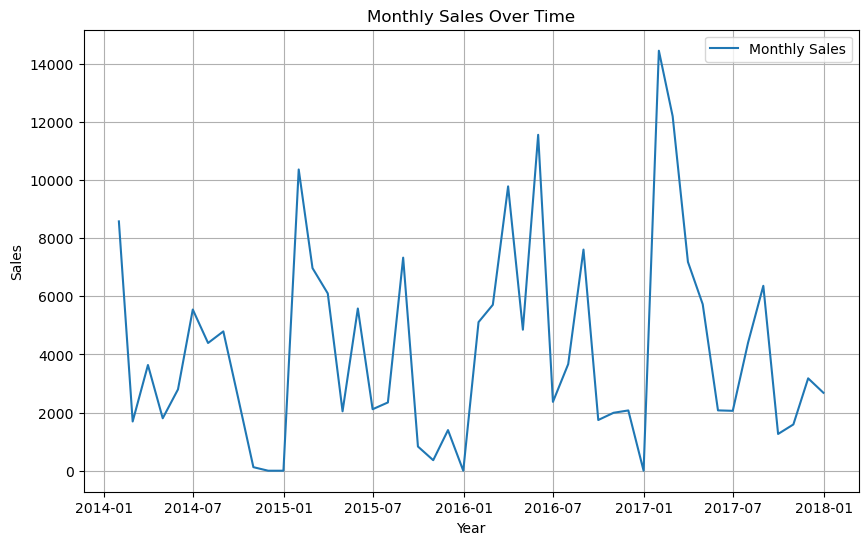

In [23]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales, label='Monthly Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

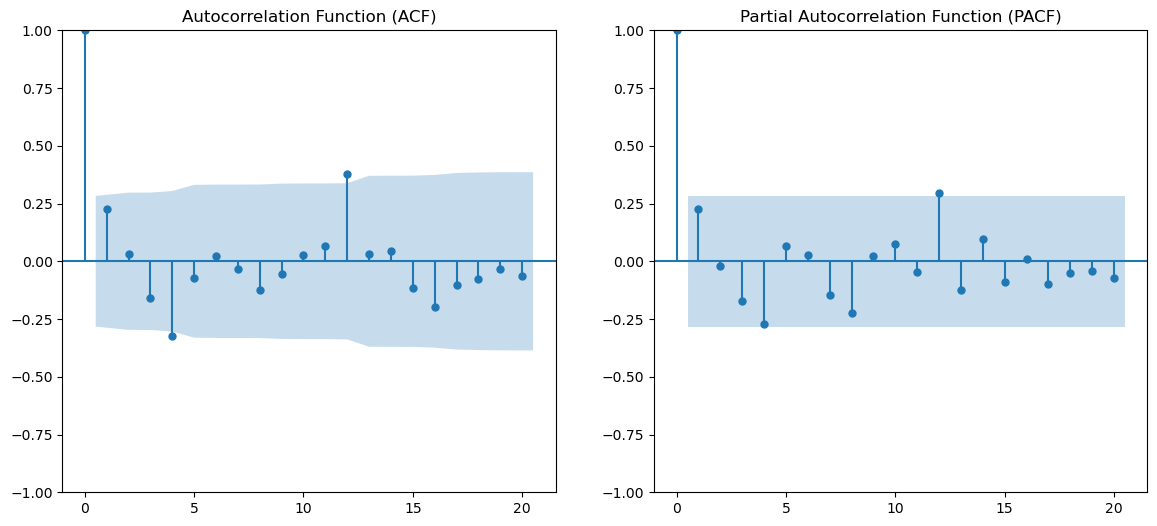

In [24]:
# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(monthly_sales, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(monthly_sales, lags=20, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

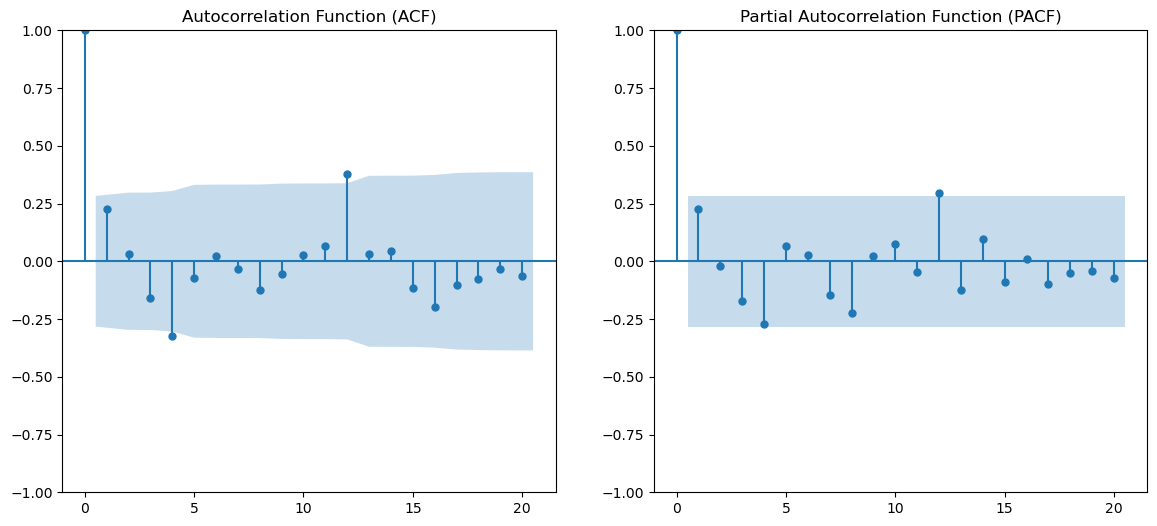

In [7]:
# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(monthly_sales, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(monthly_sales, lags=20, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()


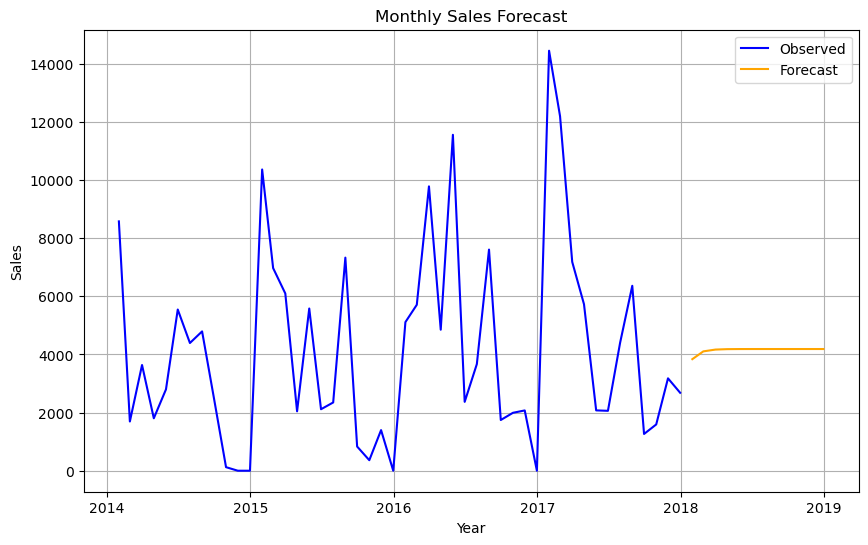

In [25]:
# Fit ARIMA(1, 0, 0) model
model_100 = ARIMA(monthly_sales, order=(1, 0, 0)).fit()

# Forecasting the next 12 months
forecast = model_100.get_forecast(steps=12)
forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='M')
forecast_values = forecast.predicted_mean
# Plotting the actual data along with the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales, label='Observed', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange')
plt.title('Monthly Sales Forecast')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

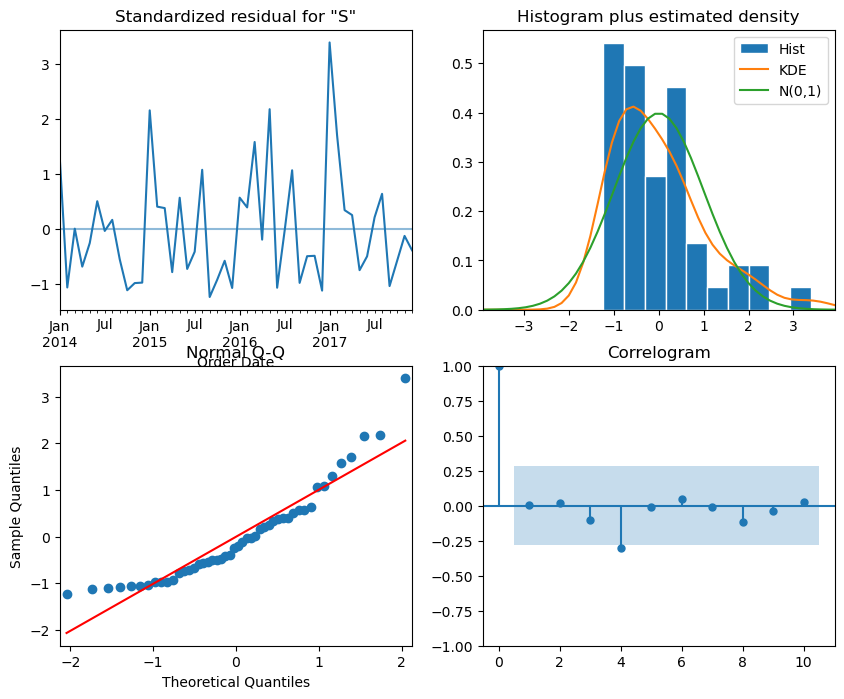

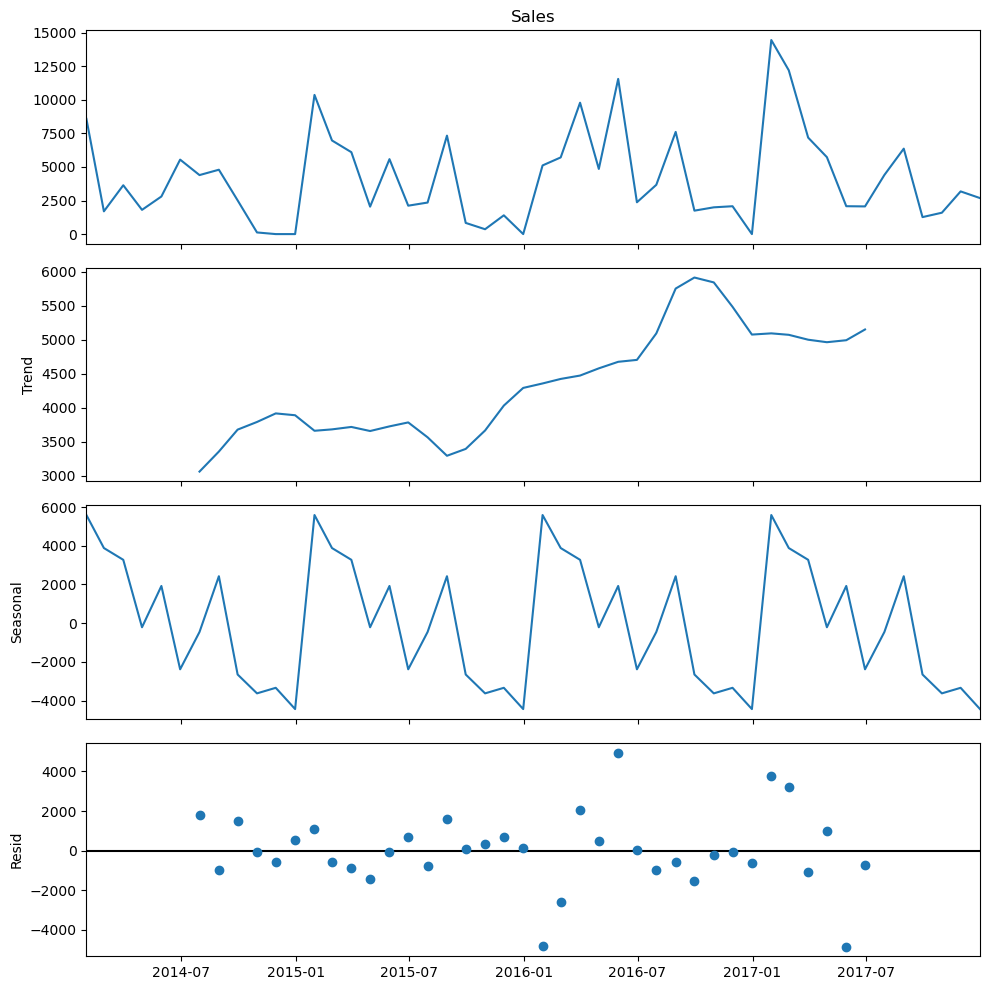

In [26]:
# Model diagnostics
model_100.plot_diagnostics(figsize=(10, 8))
plt.show()

# Decompose the time series to check for seasonality
decomposition = seasonal_decompose(monthly_sales, model='additive', period=12)

# Plot the decomposition
plt.rcParams.update({'figure.figsize': (10, 10)})
decomposition.plot()
plt.show()

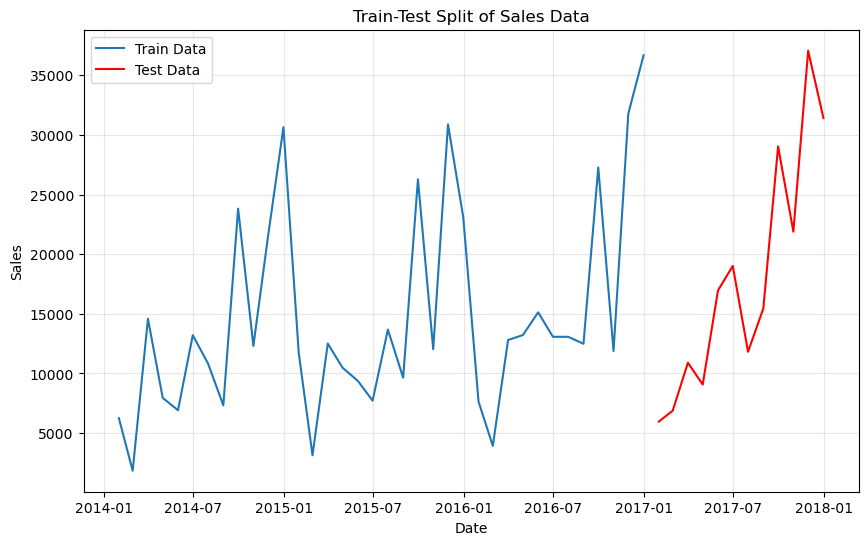

In [27]:
# Ensure the index is datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce')
data.set_index('Order Date', inplace=True)

# Optional: Resample to monthly data to reduce congestion
monthly_data = data['Sales'].resample('M').sum()

# Train-test split (last 12 months as test)
train_data = monthly_data[:-12]
test_data = monthly_data[-12:]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Train Data')
plt.plot(test_data.index, test_data, label='Test Data', color='red')
plt.title('Train-Test Split of Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


C:\Users\rabhi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


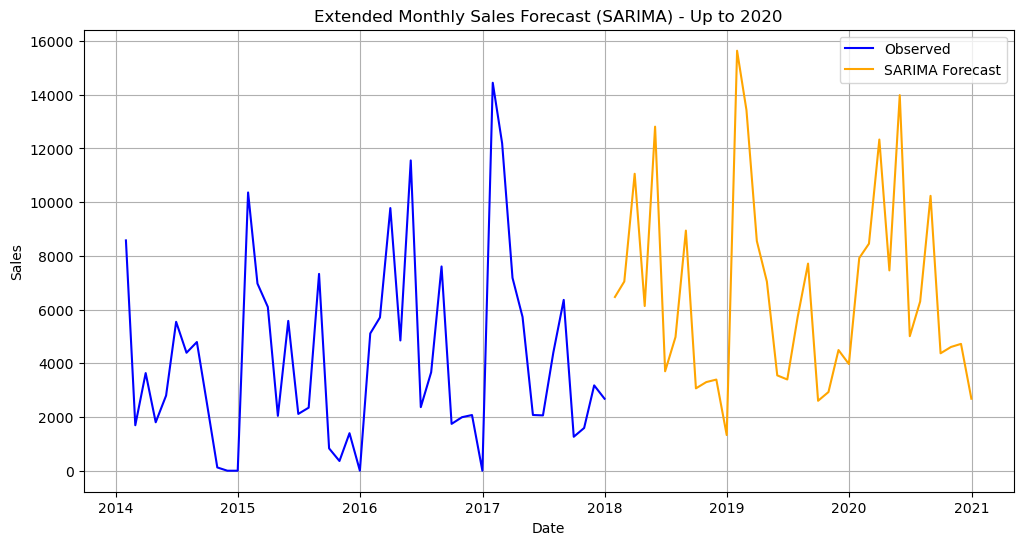

In [28]:
# Define the SARIMA model - we start with an initial guess for the parameters
sarima_model = SARIMAX(monthly_sales, 
                       order=(1, 1, 1), 
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

# Fit the SARIMA model
sarima_model_fit = sarima_model.fit()

# Extend the forecast to cover up to 2020
extended_periods = (2020 - monthly_sales.index[-1].year) * 12 + (12 - monthly_sales.index[-1].month)
extended_sarima_forecast = sarima_model_fit.get_forecast(steps=extended_periods)
extended_forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.offsets.MonthEnd(1), periods=extended_periods, freq='M')
extended_sarima_forecast_values = extended_sarima_forecast.predicted_mean

# Plotting the actual data along with the extended SARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Observed', color='blue')
plt.plot(extended_forecast_index, extended_sarima_forecast_values, label='SARIMA Forecast', color='orange')
plt.title('Extended Monthly Sales Forecast (SARIMA) - Up to 2020')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\rabhi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


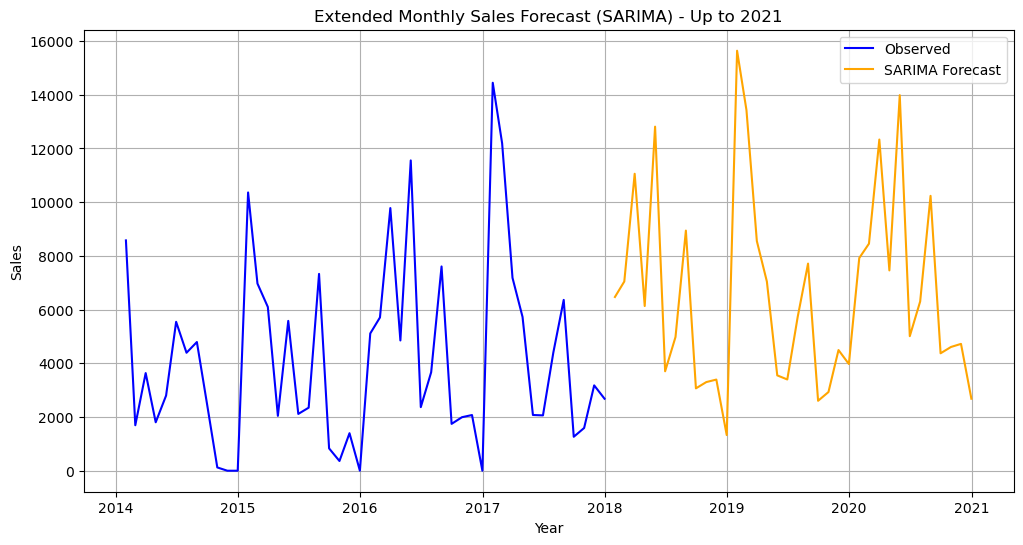

In [29]:
# Fit the SARIMA model
sarima_model_fit = sarima_model.fit()

# Extend the forecast to cover up to 2020
extended_periods = (2020 - monthly_sales.index[-1].year) * 12 + (12 - monthly_sales.index[-1].month)
extended_sarima_forecast = sarima_model_fit.get_forecast(steps=extended_periods)
extended_forecast_index = pd.date_range(start=monthly_sales.index[-1] + pd.offsets.MonthEnd(1), periods=extended_periods, freq='M')
extended_sarima_forecast_values = extended_sarima_forecast.predicted_mean

# Plotting the actual data along with the extended SARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Observed', color='blue')
plt.plot(extended_forecast_index, extended_sarima_forecast_values, label='SARIMA Forecast', color='orange')
plt.title('Extended Monthly Sales Forecast (SARIMA) - Up to 2021')

plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xlabel('Year')
plt.show()